In [ ]:
%matplotlib inline

!pip install keras
!pip install tensorflow  
!pip3 install opencv-python
!pip install pypng
!pip install matplotlib

from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import data,filters
from PIL import ImageTk, Image

drive.mount('/content/drive')
%cd /content/drive/MyDrive/analog/

import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
import pathlib
import PIL
import os,png,array
import pandas as pd
import time

     |████████████████████████████████| 655kB 5.7MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=bde46c8b378bb1416675e4986afa24acd97ddaee019c4d71512018767f6896eb
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng
Mounted at /content/drive
/content/drive/MyDrive/analog


SAYAC (114).jpg SAYAÇ MİKTAR: 00530None
SAYAC (47).jpg SAYAÇ MİKTAR: 003596
SAYAC (42).jpg SAYAÇ MİKTAR: 0040NoneNone
SAYAC (92).jpg SAYAÇ MİKTAR: 006980
SAYAC (145).jpg SAYAÇ MİKTAR: 000800
SAYAC (75).jpg SAYAÇ MİKTAR: 00350None
SAYAC (129).jpg SAYAÇ MİKTAR: 002660
SAYAC (62).jpg SAYAÇ MİKTAR: 003200
SAYAC (119).jpg SAYAÇ MİKTAR: 000246
SAYAC (71).jpg SAYAÇ MİKTAR: 006430
SAYAC (51).jpg SAYAÇ MİKTAR: 000313
SAYAC (140).jpg SAYAÇ MİKTAR: 00870None
SAYAC (139).jpg SAYAÇ MİKTAR: 000490
SAYAC (10).jpg SAYAÇ MİKTAR: 000523
SAYAC (3).jpg SAYAÇ MİKTAR: 000521
SAYAC (2).jpg SAYAÇ MİKTAR: 000513
SAYAC (57).jpg SAYAÇ MİKTAR: 006210
SAYAC (104).jpg SAYAÇ MİKTAR: 000724
SAYAC (108).jpg SAYAÇ MİKTAR: 002330
SAYAC (168).jpg SAYAÇ MİKTAR: 00330None
SAYAC (138).jpg SAYAÇ MİKTAR: 00090None
SAYAC (24).jpg SAYAÇ MİKTAR: 200516
SAYAC (77).jpg SAYAÇ MİKTAR: 003669
SAYAC (127).jpg SAYAÇ MİKTAR: 002580
SAYAC (8).jpg SAYAÇ MİKTAR: 000525
SAYAC (76).jpg SAYAÇ MİKTAR: 000367
SAYAC (110).jpg SAYAÇ MİKTAR: 00334

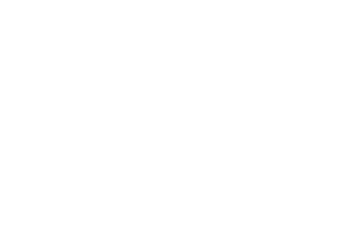

In [ ]:
from keras.models import load_model
classifier=load_model('cnn_svhn_.model')

row_list = []
index_counter = 0
resize_counter = 0

directory="/content/drive/My Drive/analog/"

for file in os.listdir(directory):
  try:

    if file.endswith(".jpg"): 
        img = cv2.imread(file, 0)

        img = cv2.GaussianBlur(img, (3,3), 0)

        #edges = cv2.Canny(img, 175, 200, apertureSize=3, L2gradient=False)
        def auto_canny(image, sigma=0.33):

            v = np.median(image)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
            return edged

        edges = auto_canny(img)

        contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        contours_dict = dict()
        for cont in contours:
            x, y, w, h = cv2.boundingRect(cont)
            area = cv2.contourArea(cont)
            if 20 < area and 20 < w and h > 10 :
                contours_dict[(x, y, w, h)] = cont

        contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)
        blank_background = np.zeros_like(edges)
        img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)

        def is_overlapping_horizontally(box1, box2):
            x1, _, w1, _ = box1
            x2, _, _, _ = box2
            if x1 > x2:
                return is_overlapping_horizontally(box2, box1)
            return (x2 - x1) < w1

        def merge(box1, box2):
            assert is_overlapping_horizontally(box1, box2)
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            x = min(x1, x2)
            w = max(x1 + w1, x2 + w2) - x
            y = min(y1, y2)
            h = max(y1 + h1, y2 + h2) - y
            return (x, y, w, h)

        def windows(contours):
            boxes = []
            for cont in contours:
                box = cv2.boundingRect(cont)
                if not boxes:
                    boxes.append(box)
                else:
                    if is_overlapping_horizontally(boxes[-1], box):
                        last_box = boxes.pop()
                        merged_box = merge(box, last_box)
                        boxes.append(merged_box)
                    else:
                        boxes.append(box)
            return boxes

        boxes = windows(contours_filtered)
        len_boxes = len(boxes)

        for n in range(len_boxes):
          x, y, w, h = boxes[n]
          plt.axis('off')
          
          if y < 10:
              y = 10
          if x < 10:
              x = 10
              
          roi = img[y-10:y+h+5, x-10:x+w+5]
          roi = cv2.resize(roi,(32, 32),interpolation = cv2.INTER_AREA)
          a = str(n+1)
          cv2.imwrite('basamak'+a+'.png', roi)

        columnNames = list()

        for i in range(1024):
            pixel = 'pixel'
            pixel += str(i)
            columnNames.append(pixel)

        train_data = pd.DataFrame(columns = columnNames)

        for n in range(len_boxes):
            a = str(n+1)
            b='basamak'+a+'.png'
            img = Image.open(b)
            rawData = img.load()
            data = []
            for y in range(32):
                for x in range(32):
                    data.append(rawData[x,y])
            k = 0
            train_data.loc[0] = [data[k] for k in range(1024)]
            train_data = train_data.div(255)
            train_data.to_csv("train_converted"+a+".csv",index = False)


        w ={}
        for n in range(len_boxes):
            a = str(n+1)
            b = "train_converted"+a+".csv"
            x_pred = pd.read_csv(b)
            x_pred = x_pred.iloc[:,:].values.astype('float32')
            x_pred =x_pred.reshape(-1, 32, 32, 1)
            predictions=classifier.predict(x_pred)
            x = predictions[4]
            c = "predictions"+a
            w.update( {c : x.argmax()} )
        
        row = [file,  str(w.get("predictions1")) + 
               str(w.get("predictions2")) +  
               str(w.get("predictions3")) +
               str(w.get("predictions4")) +
               str(w.get("predictions5")) +
               str(w.get("predictions6")) ]

        row_list.append(row)

        print( file + " " + "SAYAÇ MİKTAR: " +
            str(w.get("predictions1")) + 
            str(w.get("predictions2")) +  
            str(w.get("predictions3")) +
            str(w.get("predictions4")) +
            str(w.get("predictions5")) +
            str(w.get("predictions6")) 
            )

        continue
        
    else:
        continue

  except IndexError:
    if IndexError:
      index_counter += 1
      print(file + " " +'List index out of range error')
      print('index count: ', index_counter)
      pass

  '''except:
    row = [file, "Resize Error"]
    resize_counter += 1
    print('resize count: ', resize_counter)
    print(file + " " + 'resize error')'''

In [ ]:
# Create a file for new predicted values, then write it
# update this csv each time you changed something in the code above 
# then follow these steps and calculate the accuracy, compare with other results
with open('analog_predicted_meter.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerows(row_list)
print(len(row_list))

169


In [ ]:
print("-------------------------------------")
print("resize counter error:", " ", resize_counter)
print("index counter error:" , " " , index_counter)
print("-------------------------------------")
read = 169 - (int(resize_counter) + int(index_counter))
not_read = int(resize_counter) + int(index_counter)
print("reading: ", read)
print("not reading: ", not_read)
print("-------------------------------------")

-------------------------------------
resize counter error:   0
index counter error:   0
-------------------------------------
reading:  169
not reading:  0
-------------------------------------


In [ ]:
read_value = pd.read_csv("analog_predicted_meter.csv")
read_value.columns = ["imageID", "read_value"]
read_value["imageID"] = read_value["imageID"].str.replace(r'.jpg$', '')
#read_val["ImageID"] = read_val["ImageID"].str.replace(r'.png$', '')

# Delete basamak.png rows
#read_val = read_val[read_val.ReadValue == basamak]

read_value

,imageID,read_value
0,SAYAC (47),003596
1,SAYAC (42),0040NoneNone
2,SAYAC (92),006980
3,SAYAC (145),000800
4,SAYAC (75),00350None
...,...,...
163,SAYAC (122),000555
164,SAYAC (6),000530
165,SAYAC (164),000560
166,SAYAC (146),008110


In [ ]:
real_value = pd.read_excel("analog_actual_meter.xlsx", dtype={'actual_value':np.str})
real_value

,imageID,actual_value
0,SAYAC (1),000494
1,SAYAC (2),000513
2,SAYAC (3),000521
3,SAYAC (4),000521
4,SAYAC (5),000522
...,...,...
164,SAYAC (165),000496
165,SAYAC (166),000496
166,SAYAC (167),000503
167,SAYAC (168),000507


In [ ]:
merged = pd.merge(read_value, real_value, on="imageID")
%load_ext google.colab.data_table 
merged

,imageID,read_value,actual_value
0,SAYAC (47),003596,000597
1,SAYAC (42),0040NoneNone,000589
2,SAYAC (92),006980,000698
3,SAYAC (145),000800,000810
4,SAYAC (75),00350None,000663
...,...,...,...
162,SAYAC (122),000555,000753
163,SAYAC (6),000530,000523
164,SAYAC (164),000560,000496
165,SAYAC (146),008110,000811


In [ ]:
merged["read_value"] = merged["read_value"].str.replace(r'None', 'N')
merged

,imageID,read_value,actual_value
0,SAYAC (47),003596,000597
1,SAYAC (42),0040NN,000589
2,SAYAC (92),006980,000698
3,SAYAC (145),000800,000810
4,SAYAC (75),00350N,000663
...,...,...,...
162,SAYAC (122),000555,000753
163,SAYAC (6),000530,000523
164,SAYAC (164),000560,000496
165,SAYAC (146),008110,000811


In [ ]:
merged['IfMatch'] = np.where(merged['read_value'] == merged['actual_value'], 'True', 'False')
merged[merged['IfMatch'] == 'True']
#merged

,imageID,read_value,actual_value,IfMatch
13,SAYAC (3),000521,000521,True
14,SAYAC (2),000513,000513,True
16,SAYAC (104),000724,000724,True
33,SAYAC (30),000558,000558,True
56,SAYAC (4),000521,000521,True
63,SAYAC (151),000828,000828,True
82,SAYAC (98),000712,000712,True
87,SAYAC (7),000523,000523,True
107,SAYAC (162),000842,000842,True
109,SAYAC (44),000594,000594,True


In [ ]:
merged["Total"] = merged['read_value'] 

for row in range(167):

  match_counter = 0

  for basamak in range(6):
    if merged['read_value'][row][basamak]== merged['actual_value'][row][basamak]:
      match_counter += 1

  merged['Total'][row] = match_counter

In [ ]:
merged["digit_correctness_of_each_meter"] = (merged["Total"]/6)*100
 
print("accuracy:", (sum (merged["Total"])/ (6*167))*100)

merged

accuracy: 57.08582834331337


,imageID,read_value,actual_value,IfMatch,Total,digit_correctness_of_each_meter
0,SAYAC (47),003596,000597,False,4,66.6667
1,SAYAC (42),0040NN,000589,False,2,33.3333
2,SAYAC (92),006980,000698,False,2,33.3333
3,SAYAC (145),000800,000810,False,5,83.3333
4,SAYAC (75),00350N,000663,False,2,33.3333
...,...,...,...,...,...,...
162,SAYAC (122),000555,000753,False,4,66.6667
163,SAYAC (6),000530,000523,False,4,66.6667
164,SAYAC (164),000560,000496,False,3,50
165,SAYAC (146),008110,000811,False,3,50
